# 1.8 Randomized Singular Value Decomposition (SVD)
* 이번 section에서는 데이터 X행렬의 열공간을 무작위로 샘플링하며, SVD에서 U행렬의 주요 열에 걸쳐있을 부분 공간을 찾을 것이다.

    * 더 빠르게 계산할 수 있는 수학적인 방법을 살펴본다.
 
    * Step1. random projection  $P \in R^ {m\times r}$ 
        * $ Z = X*P $  &rarr;  열공간의 축소
        * $ Z = Q*R $  &rarr; $Q : orthogonal basis for Z,(and X) $
        
        <img src="fig/fig3.png" width="40%" height="30%" title="svd" alt="RubberDuck"></img>

        * $P$는 캡쳐하려는 순위 만큼만 열을 갖는 tall_skinny matrix
        * $X$의 모든 열공간을 샘플링한다. $Z$에는 $X$의 지배적인 열공간이 캡쳐된다.


    * Step2. project $X into Q$, $Y = Q^T * X$
    * SVD $Y$ = $U_Y \Sigma V^T $ &rarr; $ \Sigma V^T $ 는 $X$와 동일하다. (정의)
    * $U_X = Q*U_Y$
    * $X$의 SVD를 직접계산하는 것보다 훨씬 적은 비용으로 계산할 수 있다.


&rarr; 요약 : 데이터가 큰 X의 SVD를 계산하는 것은 큰 비용이 들어가는 계산이다. 이때 r의 낮은 순위를 이용하여 축소하여 계산하면 적은 비용으로 SVD를 계산할 수 있다.

* 랜덤 행렬 P의 선택
* 구조화된 랜텀 투영 행렬은 효율적으로 스케치를 제공하며, 계산 비용을 줄일 수 있다.

# 랜덤 SVD Example
* 고해상도의 이미지를 분해.
* 아래 예시의 함수를 사용하여 고해상도 이미지에 대한 순위 400의 근사치를 얻는다.
* 데이터를 정확하고 효율적으로 표현하지만, 훨씬 적은 계산 시간이 소요된다.

In [8]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import os

plt.rcParams['figure.figsize'] = [16,6]
plt.rcParams.update({'font.size': 18})

## 함수 정의
# Define randomized SVD function
# 원본 데이터 행렬 X를 사용

def rSVD(X,r,q,p):
    # Step 1: Sample column space of X with P matrix
    ny = X.shape[1] #열 갯수
    P = np.random.randn(ny,r+p) #목표순위인 r + p만큼 몇 개를 더 샘플링
    Z = X @ P #X와 동일한 종류의 주요 열 SVD를 가진다.

    for k in range(q):
        Z = X @ (X.T @ Z)

    Q, R = np.linalg.qr(Z,mode='reduced') #QR분해를 통해 Z의 직교기저를 얻는다.

    # Step 2: Compute SVD on projected Y = Q.T @ X
    Y = Q.T @ X
    UY, S, VT = np.linalg.svd(Y,full_matrices=0)
    U = Q @ UY

    return U, S, VT

---------------------------

* 목성의 고해상도 이미지를 플로팅.

In [10]:
A = imread(os.path.join('..','DATA','jupiter.jpg'))
X = np.mean(A,axis=2) # Convert RGB -> grayscale

U, S, VT = np.linalg.svd(X,full_matrices=0) # Deterministic SVD

r = 400 # Target rank
q = 1   # Power iterations
p = 5   # Oversampling parameter

# 405열을 샘플링

rU, rS, rVT = rSVD(X,r,q,p)

In [11]:
## Reconstruction
XSVD = U[:,:(r+1)] @ np.diag(S[:(r+1)]) @ VT[:(r+1),:] # SVD approximation
errSVD = np.linalg.norm(X-XSVD,ord=2) / np.linalg.norm(X,ord=2)

XrSVD = rU[:,:(r+1)] @ np.diag(rS[:(r+1)]) @ rVT[:(r+1),:] # SVD approximation
errSVD = np.linalg.norm(X-XrSVD,ord=2) / np.linalg.norm(X,ord=2)

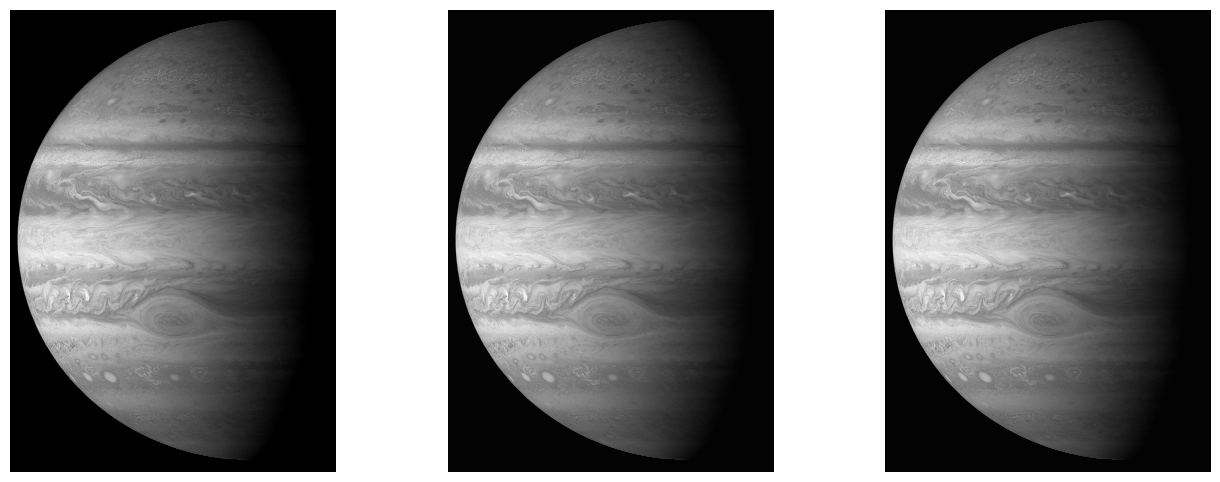

In [12]:
## Plot
fig, axs = plt.subplots(1,3)

plt.set_cmap('gray')
axs[0].imshow(X) #원본
axs[0].axis('off')
axs[1].imshow(XSVD)
axs[1].axis('off')
axs[2].imshow(XrSVD) #랜덤 SVD
axs[2].axis('off')

plt.show()

* 3장의 목성사진의 차이를 구분할 수 없다.
* 원본, rank 400 SVD, rank 400의 랜덤 SVD 

----------------------------------------------------------------------------------------------------------------------------

* 거듭제곱 반복 사용 예시
* 무작위 SVD는 특이값이 매우 빠르게 붕괴된다는 사실에 의존한다.
* 특이값은 원하는 만큼 낮은 순위로 보이지 않을 때가 많다. 더 느리게 감소(아래 그래프의 검은색 선)
* $ (X * X^T)^q *X $ : q의 수가 증가할수록 점점 더 빠르게 감소한다.


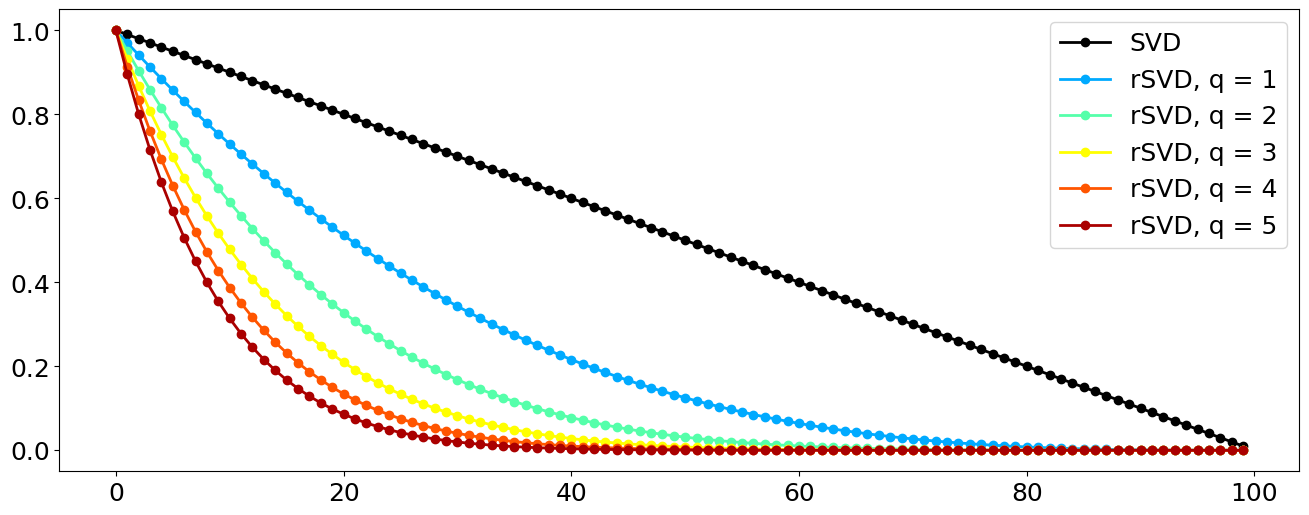

In [5]:
## Illustrate power iterations
X = np.random.randn(1000,100) #랜덤 1000 * 100 행렬 생성
U, S, VT = np.linalg.svd(X,full_matrices=0)
S = np.arange(1,0,-0.01)
X = U @ np.diag(S) @ VT

color_list = np.array([[0,0,2/3],  # Define color map
                 [0,0,1],
                 [0,1/3,1],
                 [0,2/3,1],
                 [0,1,1],
                 [1/3,1,2/3],
                 [2/3,1,1/3],
                 [1,1,0],
                 [1,2/3,0],
                 [1,1/3,0],
                 [1,0,0],
                 [2/3,0,0]])

plt.plot(S,'o-',color='k',linewidth=2,label='SVD')

Y = X
for q in range(1,6):
    Y = X.T @ Y
    Y = X @ Y
    Uq, Sq, VTq = np.linalg.svd(Y,full_matrices=0)
    plt.plot(Sq,'-o',color=tuple(color_list[2*q+1]),linewidth=2,label='rSVD, q = '+str(q))

plt.legend()
plt.show() #거듭제곱의 반복을 통해 특이값의 붕괴가 가파르게 되어 특이값 추정이 더 향상된다.